In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import pathlib
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau




In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
data_dir = pathlib.Path(path)
print(f"Path to dataset files: {data_dir}")

# Define transformations for the input images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3-channel RGB (required by ViT)
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.ToTensor(),  # Convert image to a tensor with values in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1]
])

# Load training and validation datasets using torchvision's ImageFolder
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=transform)
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=transform)

# Create DataLoader objects to enable batch processing
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)


# Vision Transformer (ViT) Implementation
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
         # (i) Calculating the number of patches
        self.num_patches = (img_size // patch_size) ** 2  # Total number of patches (14x14 = 196 for a 224x224 image)
        # (iii) Creating the projection layer
        self.projection = nn.Conv2d(in_channels,       # 3 channels (RGB)
                                    embed_dim,         # The embedding dimension (size of the resulting vector)
                                    kernel_size=patch_size,  # Size of the patches (16x16)
                                    stride=patch_size)       # Set to be the same as kernel_size to ensure Non-overlapping patches

    def forward(self, x):
        # (i) Splitting the Image into Patches + (iii) Projecting Each Patch to a Vector (Embedding)
        x = self.projection(x)  # Produces a tensor of shape [batch_size, embed_dim, 14, 14]

        # (ii) Flattening Each Patch
        x = x.flatten(2)  # Flatten to [batch_size, embed_dim, num_patches] (14x14 patches = 196)

        # (iv) Stacking Patches into a Sequence
        x = x.transpose(1, 2)  # Rearrange to [batch_size, num_patches, embed_dim]
        return x

#  Step-by-Step Process:
    # (i) Splitting the Image into Patches (Non-Overlapping)
    # (ii) Flattening Each Patch (Making them 1D)
    # (iii) Projecting Each Patch to a Vector (Embedding)
    # (iv) Stacking Patches into a Sequence


class PositionEmbedding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x):
        batch_size = x.size(0)
        cls_token = nn.Parameter(torch.randn(1, 1, x.size(-1))).to(device)
        cls_token = cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding
        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attention(self.layernorm1(x), self.layernorm1(x), self.layernorm1(x))[0]
        x = x + self.mlp(self.layernorm2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, embed_dim=768, num_heads=8, mlp_dim=2048, num_layers=6, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = (img_size // patch_size) ** 2
        self.position_embedding = PositionEmbedding(self.num_patches, embed_dim)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])

        self.layernorm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.position_embedding(x)

        for block in self.encoder:
            x = block(x)

        x = self.layernorm(x)
        cls_token = x[:, 0]
        return self.classifier(cls_token)




Using device: cuda
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [10]:
import torch
import numpy as np
from collections import Counter

# Initialize model
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
num_epochs = 10
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    # Validation Phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    epoch_predictions = []  # To store predictions for the current epoch
    epoch_true_labels = []  # To store true labels for the current epoch

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save predictions and true labels for this batch
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    # Analyze the predictions made during this epoch
    prediction_counts = Counter(epoch_predictions)
    print(f"Prediction counts for epoch {epoch+1}: {prediction_counts}")

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)

    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%\n')


KeyboardInterrupt: 

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# After training, your predictions and labels should be stored in:
# all_predictions - a list of lists where each inner list is predictions for one epoch
# all_true_labels - a list of lists where each inner list is true labels for one epoch

def analyze_predictions(all_predictions, all_true_labels):
    num_epochs = len(all_predictions)
    class_counts_per_epoch = []

    # Count predictions for each epoch
    for epoch in range(num_epochs):
        epoch_prediction_counts = Counter(all_predictions[epoch])
        class_counts_per_epoch.append(epoch_prediction_counts)
        print(f"Epoch {epoch + 1} Prediction Counts: {epoch_prediction_counts}")

    # Plot the prediction distribution over epochs
    plt.figure(figsize=(12, 6))
    for label in range(4):  # Assuming 4 classes: 0, 1, 2, 3
        counts = [epoch_counts.get(label, 0) for epoch_counts in class_counts_per_epoch]
        plt.plot(range(1, num_epochs + 1), counts, label=f"Class {label}")

    plt.xlabel("Epoch")
    plt.ylabel("Prediction Count")
    plt.title("Prediction Distribution Across Epochs")
    plt.legend()
    plt.show()

    # Check if the model is just predicting one or two classes repeatedly
    flat_predictions = [item for sublist in all_predictions for item in sublist]
    prediction_counts = Counter(flat_predictions)
    print(f"\nOverall Prediction Counts Across All Epochs: {prediction_counts}")

    # Calculate overall accuracy
    flat_true_labels = [item for sublist in all_true_labels for item in sublist]
    correct_predictions = sum([1 for pred, true in zip(flat_predictions, flat_true_labels) if pred == true])
    overall_accuracy = 100 * correct_predictions / len(flat_true_labels)
    print(f"Overall Accuracy Across All Epochs: {overall_accuracy:.2f}%")

# Run the analysis function
analyze_predictions(all_predictions, all_true_labels)


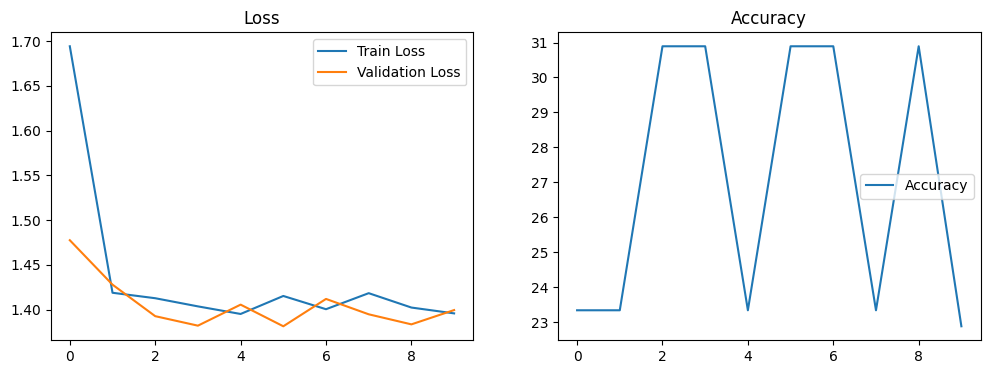

In [4]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [9]:
#pip install timm

from collections import Counter
print(Counter(train_set.targets))
print(Counter(val_set.targets))


Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})
Counter({2: 405, 1: 306, 0: 300, 3: 300})


In [11]:
import torch
import timm  # PyTorch Image Models library
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import pathlib
import os
import kagglehub
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [17]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
data_dir = pathlib.Path(path)
print(f"Path to dataset files: {data_dir}")

# Define transformations for the input images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3-channel RGB (required by ViT)
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.ToTensor(),  # Convert image to a tensor with values in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1]
])

# Load training and validation datasets using torchvision's ImageFolder
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=transform)
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=transform)

# Create DataLoader objects to enable batch processing
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# Load a pre-trained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task
model.to(device)
model.train()  # Set model to training mode

# Print the model architecture
print(model)

In [18]:


import torch
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to track metrics
train_loss_list = []
val_loss_list = []
accuracy_list = []
all_predictions = []  # To store predictions for all epochs
all_true_labels = []  # To store true labels for all epochs

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and true labels
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    # Calculate validation loss and accuracy
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)

    # Store predictions for later analysis
    all_predictions.append(epoch_predictions)
    all_true_labels.append(epoch_true_labels)

    # Print metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

    # Display prediction distribution for this epoch
    epoch_prediction_counts = Counter(epoch_predictions)
    print(f"Prediction counts for epoch {epoch+1}: {epoch_prediction_counts}\n")

print("Training complete.")


SyntaxError: invalid syntax (<ipython-input-18-6f8348c18d5b>, line 28)

In [ ]:
def analyze_predictions(all_predictions, all_true_labels):
    num_epochs = len(all_predictions)
    class_counts_per_epoch = []

    for epoch in range(num_epochs):
        epoch_prediction_counts = Counter(all_predictions[epoch])
        class_counts_per_epoch.append(epoch_prediction_counts)
        print(f"Epoch {epoch + 1} Prediction Counts: {epoch_prediction_counts}")

    # Plot the prediction distribution over epochs
    plt.figure(figsize=(12, 6))
    for label in range(4):  # Assuming 4 classes: 0, 1, 2, 3
        counts = [epoch_counts.get(label, 0) for epoch_counts in class_counts_per_epoch]
        plt.plot(range(1, num_epochs + 1), counts, label=f"Class {label}")

    plt.xlabel("Epoch")
    plt.ylabel("Prediction Count")
    plt.title("Prediction Distribution Across Epochs")
    plt.legend()
    plt.show()

    # Check if the model is just predicting one or two classes repeatedly
    flat_predictions = [item for sublist in all_predictions for item in sublist]
    prediction_counts = Counter(flat_predictions)
    print(f"\nOverall Prediction Counts Across All Epochs: {prediction_counts}")

    # Calculate overall accuracy
    flat_true_labels = [item for sublist in all_true_labels for item in sublist]
    correct_predictions = sum([1 for pred, true in zip(flat_predictions, flat_true_labels) if pred == true])
    overall_accuracy = 100 * correct_predictions / len(flat_true_labels)
    print(f"Overall Accuracy Across All Epochs: {overall_accuracy:.2f}%")

# Run the analysis function
analyze_predictions(all_predictions, all_true_labels)


In [17]:
import os
import numpy as np
import pickle

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/train_loss_list.npy', np.array(train_loss_list))
np.save('results/val_loss_list.npy', np.array(val_loss_list))
np.save('results/accuracy_list.npy', np.array(accuracy_list))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/all_predictions.pkl', 'wb') as f:
    pickle.dump(all_predictions, f)

with open('results/all_true_labels.pkl', 'wb') as f:
    pickle.dump(all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")


All results have been successfully saved in the 'results/' directory.


In [19]:
# now let's try with more data augmentation and regularization techniques

from torchvision import transforms

# Define transformations with Data Augmentation for the training set
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3-channel RGB (required by ViT)
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Validation data should not be augmented
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load training and validation datasets using torchvision's ImageFolder
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=train_transform)
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=val_transform)

# Create DataLoader objects to enable batch processing
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)


import timm
import torch.nn as nn

# Load a pre-trained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)  # Adjust 'num_classes' to your task

# Add Dropout layers to the model (by replacing certain layers)
model.head = nn.Sequential(
    nn.Dropout(p=0.5),  # Adding dropout before the final classification layer
    nn.Linear(model.head.in_features, 4)
)

model.to(device)
model.train()  # Set model to training mode

# Print the model architecture
print(model)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:


import torch
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to track metrics
train_loss_list = []
val_loss_list = []
accuracy_list = []
all_predictions = []  # To store predictions for all epochs
all_true_labels = []  # To store true labels for all epochs

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and true labels
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    # Calculate validation loss and accuracy
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)

    # Store predictions for later analysis
    all_predictions.append(epoch_predictions)
    all_true_labels.append(epoch_true_labels)

    # Print metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

    # Display prediction distribution for this epoch
    epoch_prediction_counts = Counter(epoch_predictions)
    print(f"Prediction counts for epoch {epoch+1}: {epoch_prediction_counts}\n")

print("Training complete.")


In [ ]:
analyze_predictions(all_predictions, all_true_labels)

In [ ]:
import os
import numpy as np
import pickle

# Create a directory called "results" if it doesn't already exist
os.makedirs('results', exist_ok=True)

# Save the lists as numpy arrays for easy reloading
np.save('results/train_loss_list_aug_reg.npy', np.array(train_loss_list))
np.save('results/val_loss_list_aug_reg.npy', np.array(val_loss_list))
np.save('results/accuracy_list_aug_reg.npy', np.array(accuracy_list))

# Save predictions and true labels as pickle files (more efficient for storing lists of lists)
with open('results/all_predictions_aug_reg.pkl', 'wb') as f:
    pickle.dump(all_predictions, f)

with open('results/all_true_labels_aug_reg.pkl', 'wb') as f:
    pickle.dump(all_true_labels, f)

print("All results have been successfully saved in the 'results/' directory.")
